In [14]:
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision import datasets, transforms

from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

import torch

import numpy as np

In [15]:
# Run if on a Mac
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

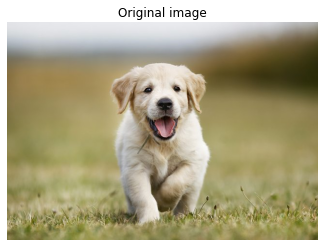

In [16]:
image = load_image('adorable_puppy.jpg')

plt.imshow(image)
plt.title('Original image')
plt.axis('off');

noisy = False

if noisy:
    noisy_img = image + np.random.normal(0, 5, (image.size[1],image.size[0], 3))

    # Prepare inputs to be used later

    img = apply_transforms(noisy_img.astype('uint8'))
else:
    img = apply_transforms(image)

In [17]:
def visualize_helper(model_module, tensor=img, k=84):
    model = model_module(pretrained=True)
    backprop = Backprop(model)
    backprop.visualize(tensor, k, guided=True)

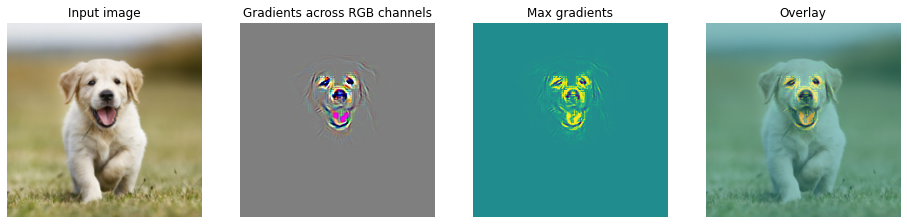

In [18]:
visualize_helper(models.alexnet)

In [19]:
# visualize_helper(models.resnet50)

In [41]:
def visualize_helper_selftrained(model, tensor=img, k=84):
    backprop = Backprop(model)
    gradients, max_gradients = backprop.visualize(tensor, k, alpha = 0, return_output = True)
    print(max_gradients)
    return gradients, max_gradients

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

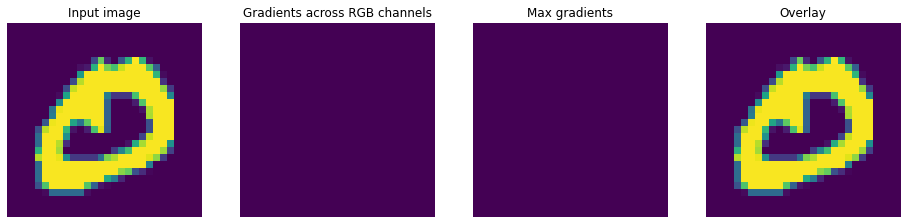

In [46]:
import sys
sys.path.insert(1, '../networks')
from starter import CNN

device = torch.device("cpu")
model = CNN().to(device)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'], map_location=device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.train()

train_loader = torch.utils.data.DataLoader( 
    datasets.MNIST('../networks/data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
        batch_size=1, shuffle=True)

for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    visualize_helper_selftrained(model, tensor=data, k=target)
    break